In [9]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import progressbar
from scipy import stats
sns.set()

%matplotlib inline

# Define path and load files 

Accross the analysis the following names are used for the 3 screens
- ova == Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [2]:
data = "../../../Paper/Data"
resultpath = '../../../Paper/Results'
if not os.path.isdir(resultpath):
    os.mkdir(resultpath)

In [25]:
PPI_ID = "2018_08"
PPI_Type = "S"

In [26]:
G = nx.read_graphml(os.path.join(data,'PPI_{}_{}.graphml'.format(PPI_Type, PPI_ID)))
hipo_ova = pd.read_csv(os.path.join(data,'Screen/hipo_ova_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen/xRNAi_fec_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(data,'Screen/hipo_fec_clean.csv'))
signaling = pd.read_csv(os.path.join(data,'signaling.csv'))
connectors= pd.read_csv(os.path.join(resultpath,"ConnectorGeneList.csv"))

In [27]:
# We only consider the sum of eggs layed over 5 days, so we restrict the data to the "Sum"
xRNAi_fec = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].reset_index(drop=True)
hipo_fec = hipo_fec[hipo_fec['Condition'] == 'Sum'].reset_index(drop=True)

# Prepare groups of genes and positive candidate set
Here we calculate the mean of the Zscore for each gene in the screens, define thresholds for significance, and create subsets of genes

In [28]:
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
mean_fec_gene = hipo_fec.groupby('FbID', as_index=False).mean()
mean_xRNAi_gene = xRNAi_fec.groupby('FbID', as_index=False).mean()

In [29]:
# We redefine our threshold of 2 and 5 for Z score cutoff
ova_threshold = 2
eggl_threshold = 5

# ROC analysis
## Define ROC function

In [30]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [31]:
def MakeRoc(data, feature, threshold):
    data = data.sort_values([feature], ascending=False)
    data.reset_index(inplace=True)
    resx = []
    resy = []
    cx = 0
    cy = 0
    for i in range(len(data)):
        if np.abs(data['Z'][i]) > threshold:
            cy += 1
        else:
            cx += 1
        resx.append(cx)
        resy.append(cy)
    resx = np.array(resx)
    resy = np.array(resy)
    
    resx = resx / resx.max()
    resy = resy / resy.max()
    
    auc = metrics.auc(resx, resy)
   
    return resx, resy, auc

In [32]:
def MakeRoc(data, feature, threshold):
    data = data.sort_values([feature], ascending=False)
    data.reset_index(inplace=True)
    resx = []
    resy = []
    cx = 0
    cy = 0
    for i in range(len(data)):
        if np.abs(data['Z'][i]) > threshold:
            cy += 1
        else:
            cx += 1
        resx.append(cx)
        resy.append(cy)
    resx = np.array(resx)
    resy = np.array(resy)
    
    resx = resx / resx.max()
    resy = resy / resy.max()
    
    auc = metrics.auc(resx, resy)
   
    return resx, resy, auc

## Calculate network features

In [33]:
# If in need to recompute change recompute to True !
recompute = False

In [34]:
# Betweenness Centrality

if os.path.isfile(os.path.join(data, "ScreenPPI_Betweenness.csv")) and not recompute:
    betweenness = pd.read_csv(os.path.join(data, "ScreenPPI_Betweenness.csv"))
else:
    betweenness = nx.betweenness_centrality(G)
    res = []
    for key in betweenness:
        res.append([key, betweenness[key]])
    betweenness = pd.DataFrame(res, columns=['FbID','Betweeness'])
    betweenness.to_csv(os.path.join(data,'ScreenPPI_Betweenness.csv'), index=False)

In [35]:
# Closeness Centrality

if os.path.isfile(os.path.join(data, "ScreenPPI_Closeness.csv")) and not recompute:
    closeness = pd.read_csv(os.path.join(data, "ScreenPPI_Closeness.csv"))
else:
    closeness = nx.closeness_centrality(G)
    res = []
    for key in closeness:
        res.append([key, closeness[key]])
    closeness = pd.DataFrame(res, columns=['FbID','Closeness'])
    closeness.to_csv(os.path.join(data,'ScreenPPI_Closeness.csv'), index=False)

In [36]:
# EigenVector Centrality

if os.path.isfile(os.path.join(data, "ScreenPPI_Eigenvector.csv")) and not recompute:
    eigenvector = pd.read_csv(os.path.join(data, "ScreenPPI_Eigenvector.csv"))
else:
    eigenvector = nx.eigenvector_centrality(G)
    res = []
    for key in eigenvector:
        res.append([key, eigenvector[key]])
    eigenvector = pd.DataFrame(res, columns=['FbID','EigenVector'])
    eigenvector.to_csv(os.path.join(data,'ScreenPPI_Eigenvector.csv'), index=False)

In [37]:
# Degree Centrality

if os.path.isfile(os.path.join(data, "ScreenPPI_DegreeCentrality.csv")) and not recompute:
    degrees_cen = pd.read_csv(os.path.join(data, "ScreenPPI_DegreeCentrality.csv"))
else:
    degrees_cen = nx.degree_centrality(G)
    res = []
    for key in degrees_cen:
        res.append([key, degrees_cen[key]])
    degrees_cen = pd.DataFrame(res, columns=['FbID','DegreeC'])
    degrees_cen.to_csv(os.path.join(data,'ScreenPPI_DegreeCentrality.csv'), index=False)

## Generate tables containing the network metrics for each screens

In [38]:
ova_meta = []
ova_genes = mean_ova_gene['FbID'].values
for gene in ova_genes:
    if gene in G.nodes():
        z = mean_ova_gene[mean_ova_gene['FbID'] == gene]['Z'].values[0]
        bc = betweenness[betweenness['FbID'] == gene]['Betweeness'].values[0]
        ec = closeness[closeness['FbID'] == gene]['Closeness'].values[0]
        cc = eigenvector[eigenvector['FbID'] == gene]['EigenVector'].values[0]
        dc = degrees_cen[degrees_cen['FbID'] == gene]['DegreeC'].values[0]
        ova_meta.append([gene, z, bc, ec, cc, dc])
ova_meta = pd.DataFrame(ova_meta, columns=['FbID', 'Z','Betweeness','EigenVector','Closeness','Degrees'])

In [39]:
fec_meta = []
fec_genes = mean_fec_gene['FbID'].values
for gene in fec_genes:
    if gene in G.nodes():
        z = mean_fec_gene[mean_fec_gene['FbID'] == gene]['Z'].values[0]
        bc = betweenness[betweenness['FbID'] == gene]['Betweeness'].values[0]
        ec = closeness[closeness['FbID'] == gene]['Closeness'].values[0]
        cc = eigenvector[eigenvector['FbID'] == gene]['EigenVector'].values[0]
        dc = degrees_cen[degrees_cen['FbID'] == gene]['DegreeC'].values[0]
        fec_meta.append([gene, z, bc, ec, cc, dc])
fec_meta = pd.DataFrame(fec_meta, columns=['FbID', 'Z','Betweeness','EigenVector','Closeness','Degrees'])

In [40]:
xRNAi_meta = []
xRNAi_genes = mean_xRNAi_gene['FbID'].values
for gene in xRNAi_genes:
    if gene in G.nodes():
        z = mean_xRNAi_gene[mean_xRNAi_gene['FbID'] == gene]['Z'].values[0]
        bc = betweenness[betweenness['FbID'] == gene]['Betweeness'].values[0]
        ec = closeness[closeness['FbID'] == gene]['Closeness'].values[0]
        cc = eigenvector[eigenvector['FbID'] == gene]['EigenVector'].values[0]
        dc = degrees_cen[degrees_cen['FbID'] == gene]['DegreeC'].values[0]
        xRNAi_meta.append([gene, z, bc, ec, cc, dc])
xRNAi_meta = pd.DataFrame(xRNAi_meta, columns=['FbID', 'Z','Betweeness','EigenVector','Closeness','Degrees'])

## Make ROC cuves for network metrics

In [41]:
netfeatures = ['Betweeness', 'EigenVector', 'Closeness', 'Degrees']

In [53]:
data = ova_meta
screenName = "Hippo RNAi Ovariole nb"

Y_test = np.array(data['Z'].abs()>2)
Y_score = data[feature].values


data = data.sort_values([feature], ascending=False)
data.reset_index(inplace=True)
roc_curve

<function sklearn.metrics.ranking.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)>

In [75]:
def MakeROC(data, test, score, threshold):
    Y_test = np.array(data['Z'].abs()>threshold)
    Y_score = data[feature].values
    
    fpr, tpr, _ = roc_curve(Y_test, Y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

Text(0, 0.5, 'True Discovery Rate')

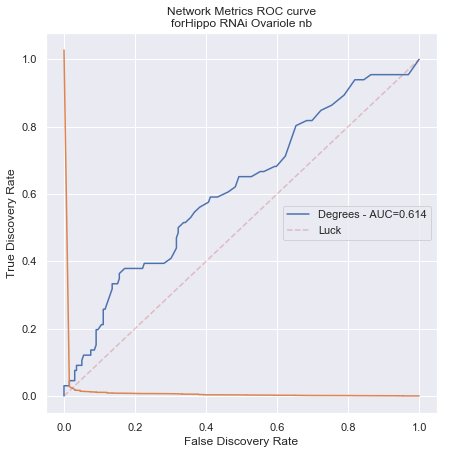

In [69]:
fig = plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label='{} - AUC={}'.format(feature, round(roc_auc,3)))
plt.plot(tpr, _)

plt.plot([0,1], [0,1], 'r--', label="Luck", alpha=0.3)
plt.legend()
plt.title("Network Metrics ROC curve\nfor{}".format(screenName))
plt.xlabel("False Discovery Rate")
plt.ylabel("True Discovery Rate")

Text(0, 0.5, 'True Discovery Rate')

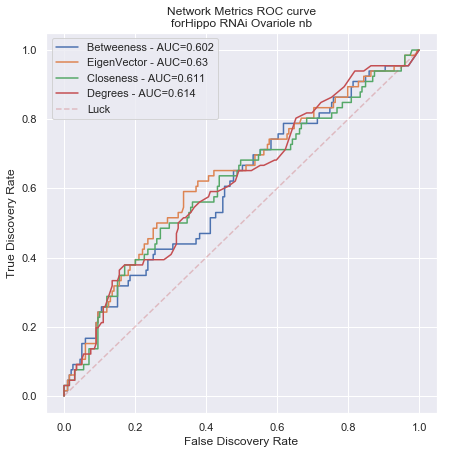

In [77]:
# Making ROC curve for Ovariole nb screen
screen = ova_meta
screenName = "Hippo RNAi Ovariole nb"

fig = plt.figure(figsize=(7,7))

for feature in netfeatures:
    X, Y, AUC = MakeROC(screen, 'Z', feature, ova_threshold)
    plt.plot(X,Y, label='{} - AUC={}'.format(feature, round(AUC,3)))

plt.plot([0,1], [0,1], 'r--', label="Luck", alpha=0.3)
plt.legend()
plt.title("Network Metrics ROC curve\nfor{}".format(screenName))
plt.xlabel("False Discovery Rate")
plt.ylabel("True Discovery Rate")

Text(0, 0.5, 'True Discovery Rate')

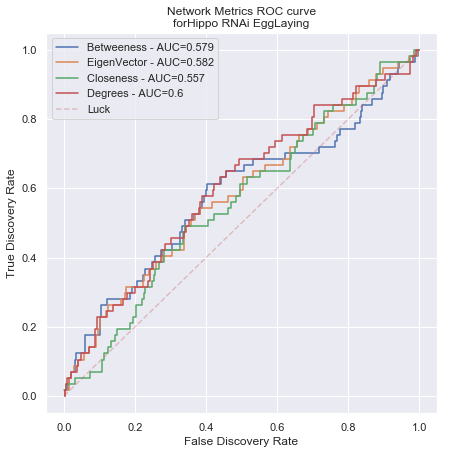

In [69]:
# Making ROC curve for Ovariole nb screen
screen = fec_meta
screenName = "Hippo RNAi EggLaying"

fig = plt.figure(figsize=(7,7))

for feature in netfeatures:
    X, Y, AUC = MakeRoc(screen, feature, threshold=eggl_threshold)
    plt.plot(X,Y, label='{} - AUC={}'.format(feature, round(AUC,3)))

plt.plot([0,1], [0,1], 'r--', label="Luck", alpha=0.3)
plt.legend()
plt.title("Network Metrics ROC curve\nfor{}".format(screenName))
plt.xlabel("False Discovery Rate")
plt.ylabel("True Discovery Rate")

Text(0, 0.5, 'True Discovery Rate')

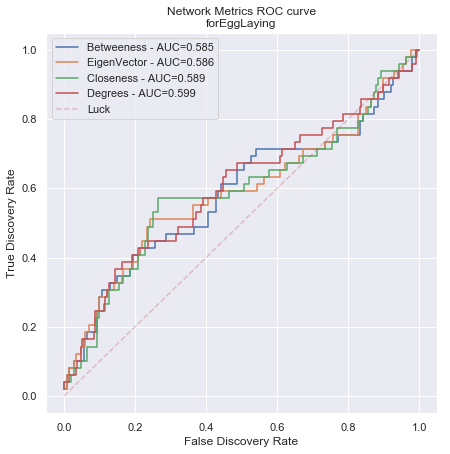

In [70]:
# Making ROC curve for Ovariole nb screen
screen = xRNAi_meta
screenName = "EggLaying"

fig = plt.figure(figsize=(7,7))

for feature in netfeatures:
    X, Y, AUC = MakeRoc(screen, feature, threshold=eggl_threshold)
    plt.plot(X,Y, label='{} - AUC={}'.format(feature, round(AUC,3)))

plt.plot([0,1], [0,1], 'r--', label="Luck", alpha=0.3)
plt.legend()
plt.title("Network Metrics ROC curve\nfor{}".format(screenName))
plt.xlabel("False Discovery Rate")
plt.ylabel("True Discovery Rate")

## Making just one figure with the 3 pannels

Hippo RNAi Ovariole nb - Betweeness | AUC = 0.6
Hippo RNAi Ovariole nb - EigenVector | AUC = 0.63
Hippo RNAi Ovariole nb - Closeness | AUC = 0.61
Hippo RNAi Ovariole nb - Degrees | AUC = 0.61
Hippo RNAi EggLaying - Betweeness | AUC = 0.58
Hippo RNAi EggLaying - EigenVector | AUC = 0.58
Hippo RNAi EggLaying - Closeness | AUC = 0.56
Hippo RNAi EggLaying - Degrees | AUC = 0.6
EggLaying - Betweeness | AUC = 0.58
EggLaying - EigenVector | AUC = 0.59
EggLaying - Closeness | AUC = 0.59
EggLaying - Degrees | AUC = 0.6


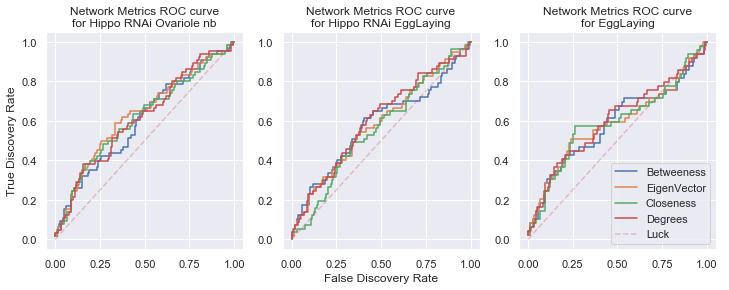

In [71]:
# Making ROC curve for Ovariole nb screen
screen = ova_meta
screenName = "Hippo RNAi Ovariole nb"

fig = plt.figure(figsize=(12,4))

# Plotting Ova nb
ax = fig.add_subplot(131)
for feature in netfeatures:
    X, Y, AUC = MakeRoc(screen, feature, threshold=ova_threshold)
    plt.plot(X,Y)
    print("{} - {} | AUC = {}".format(screenName, feature, round(AUC,2)))
    

plt.plot([0,1], [0,1], 'r--', label="Luck", alpha=0.3)
plt.title("Network Metrics ROC curve\nfor {}".format(screenName))
plt.ylabel("True Discovery Rate")


# Plotting Hippo EggL
screen = fec_meta
screenName = "Hippo RNAi EggLaying"
ax = fig.add_subplot(132)
for feature in netfeatures:
    X, Y, AUC = MakeRoc(screen, feature, threshold=eggl_threshold)
    plt.plot(X,Y)
    print("{} - {} | AUC = {}".format(screenName, feature, round(AUC,2)))

plt.plot([0,1], [0,1], 'r--', label="Luck", alpha=0.3)
plt.title("Network Metrics ROC curve\nfor {}".format(screenName))
plt.xlabel("False Discovery Rate")

# Plotting EggL
screen = xRNAi_meta
screenName = "EggLaying"
ax = fig.add_subplot(133)
for feature in netfeatures:
    X, Y, AUC = MakeRoc(screen, feature, threshold=eggl_threshold)
    plt.plot(X,Y, label='{}'.format(feature))
    print("{} - {} | AUC = {}".format(screenName, feature, round(AUC,2)))

plt.plot([0,1], [0,1], 'r--', label="Luck", alpha=0.3)
plt.legend()
plt.title("Network Metrics ROC curve\nfor {}".format(screenName))
fig.savefig(os.path.join(resultpath, "Figures/ROC_analysis.svg"))

## Do the top/bottom quantile analysis

In [72]:
def getQtile(arr, q):
    qmin = arr[:int(q*len(arr))]
    qmax = arr[int((1-q)*len(arr)):]
    return qmin, qmax

Betweeness 0.1533247342686807
EigenVector 0.07600723616486278
Closeness 0.09072326732787228
Degrees 0.012966688880008318


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Betweeness 0.2924850097676833
EigenVector 0.22825839576287993
Closeness 0.10127667702999377
Degrees 0.09482606064642446
Betweeness 0.058525039268275514
EigenVector 0.06316293039210633
Closeness 0.12561469067490472
Degrees 0.008553331212748917


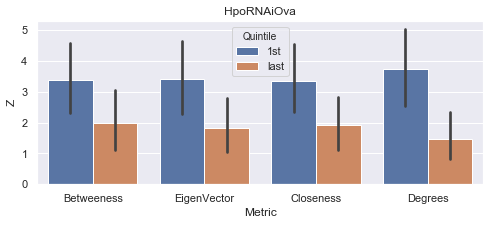

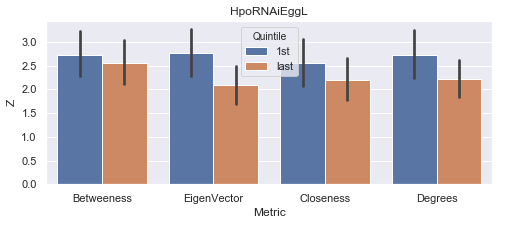

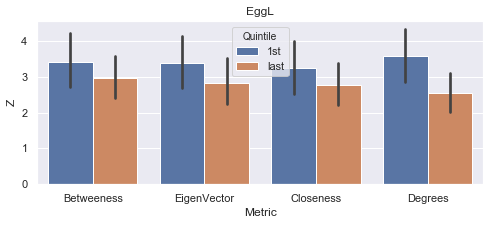

In [73]:
# Define our screens here
screens = [ova_meta, fec_meta, xRNAi_meta]
screen_labels = ['HpoRNAiOva', "HpoRNAiEggL", "EggL"]

for screen, screen_label in zip(screens, screen_labels):
    #Sort Z scores by metrics
    Betweeness_Z = screen.sort_values("Betweeness")['Z'].values
    EigenVector_Z = screen.sort_values("EigenVector")['Z'].values
    Closeness_Z = screen.sort_values("Closeness")['Z'].values
    Degrees_Z = screen.sort_values("Degrees")['Z'].values

    metrics = [Betweeness_Z, EigenVector_Z, Closeness_Z, Degrees_Z]
    labels = ["Betweeness", "EigenVector", "Closeness", "Degrees"]
    res = []
    for metric, label in zip(metrics, labels):
        qmin, qmax = getQtile(metric, 0.20)
        u, p = stats.mannwhitneyu(qmin, qmax)
        print(label, p)
        for i in qmax:
            res.append([label, "1st", np.abs(i)])
        for i in qmin:
            res.append([label, "last", np.abs(i)])
    result = pd.DataFrame(res, columns=["Metric", "Quintile", "Z"])    

    fig = plt.figure(figsize=(8,3))
    plt.title(screen_label)
    sns.barplot(data=result, x="Metric", y="Z", hue="Quintile")
    fig.savefig(os.path.join(resultpath, "Figures", "Centrality_Quintile_{}.svg".format(screen_label)))

Betweeness 0.058525039268275514
EigenVector 0.06316293039210633
Closeness 0.12561469067490472
Degrees 0.008553331212748917


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


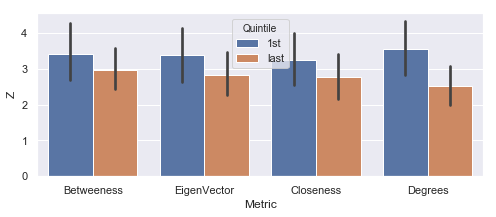

In [74]:
metrics = [Betweeness_Z, EigenVector_Z, Closeness_Z, Degrees_Z]
labels = ["Betweeness", "EigenVector", "Closeness", "Degrees"]
res = []
for metric, label in zip(metrics, labels):
    qmin, qmax = getQtile(metric, 0.20)
    u, p = stats.mannwhitneyu(qmin, qmax)
    print(label, p)
    for i in qmax:
        res.append([label, "1st", np.abs(i)])
    for i in qmin:
        res.append([label, "last", np.abs(i)])
result = pd.DataFrame(res, columns=["Metric", "Quintile", "Z"])    

fig = plt.figure(figsize=(8,3))
sns.barplot(data=result, x="Metric", y="Z", hue="Quintile")
fig.savefig(os.path.join(resultpath, "Figures", "Centrality_Quintile.svg"))